In [182]:
#necessary imports
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import Proj, transform
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from torchvision import transforms
import random
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import distance_transform_edt, gaussian_filter
from livelossplot import PlotLosses
import pickle
import bz2
import os
import torchvision.transforms.functional as F
import matplotlib.patches as patches
import time

Loading in the data 

In [192]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [193]:
df.head()

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,unique_id
0,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3332.557861,19.092411,3661.390137,364.616425,0.531211,Carlos Vera Guevara RGB,3,0,8305,...,Carlos Vera Guevara RGB,5298.555843,7709.844671,10.281385,banana,0.0,4.293300,1.674387,30,1
1,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3162.579834,2148.233398,3431.632324,2379.467041,0.511510,Carlos Vera Guevara RGB,3,0,8305,...,Carlos Vera Guevara RGB,5315.345160,8606.745732,13.528139,banana,0.0,7.702971,3.004159,112,2
2,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2893.605713,244.011108,3095.620605,451.257812,0.251310,Carlos Vera Guevara RGB,3,0,8305,...,Carlos Vera Guevara RGB,5228.142461,7935.770200,12.732366,banana,0.0,6.769828,2.640233,179,3
3,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2595.111084,1703.712402,2765.227295,1865.253418,0.217742,Carlos Vera Guevara RGB,3,0,8305,...,Carlos Vera Guevara RGB,4434.058601,8354.081799,9.867583,banana,0.0,3.933601,1.534104,93,4
4,Carlos Vera Guevara RGB_10_7600_7600_11600_116...,249.691879,123.626862,439.557648,302.768402,0.282849,Carlos Vera Guevara RGB,10,7600,7600,...,Carlos Vera Guevara RGB,8257.952942,7554.538338,17.825312,banana,0.0,13.862143,5.406236,162,5


In [194]:
df.shape

(2602, 44)

## Background Details for Class Weighting 

In [30]:
df['name'].value_counts()

name
Musacea               1471
Guaba                  523
Cacao                  233
Mango                   83
Otra variedad           80
Variedad bifurcada      71
Roble                   25
Melina                  16
Fernan Sanchez          16
Pachaco                 13
Guanabana               12
Caoba                   11
Guayacan                 8
Laurel                   6
Guachapeli               6
Achotillo                5
Sapote                   5
Yafruit                  5
Cedro                    4
Teca                     4
Naranja                  2
Fruta de Pan             1
Mandarina                1
MaraÃ±on                 1
Name: count, dtype: int64

In [31]:
#combining everything under 80 to 'other'
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

In [32]:
df['name'].value_counts()

name
Musacea          1471
Guaba             523
Otra variedad     292
Cacao             233
Mango              83
Name: count, dtype: int64

## Generating Maps

Generating a Distance Map

In [231]:
def generate_distance_map(image_shape, bbox):
    #create distance map with zeros
    distance_map = np.zeros(image_shape, dtype=np.float32)

    #extract bounding box coordinates 
    xmin, ymin, xmax, ymax = bbox.int().tolist()

    #create mask with zeros; bounding box set to 1
    mask = np.zeros(image_shape, dtype=np.uint8)
    mask[ymin:ymax, xmin:xmax] = 1

    #compute distance transform
    distance_map = distance_transform_edt(mask == 0)

    #apply Gaussian smoothing
    distance_map = gaussian_filter(distance_map, sigma=2)
    
    # Normalize the distance map to the range [0, 1]
    distance_map = distance_map / distance_map.max()  # Normalize distances to [0, 1]
    
    return distance_map

Generating a species and ID map 

In [202]:
def generate_species_and_ID_map(image_shape, bbox, species_label, ID_label):
    # Initialize maps with zeros
    species_map = np.zeros(image_shape, dtype=np.uint8)
    ID_map = np.zeros(image_shape, dtype=np.uint8)

    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.int().tolist()

    # Create masks within the bounding box
    species_map[ymin:ymax, xmin:xmax] = species_label 
    ID_map[ymin:ymax, xmin:xmax] = ID_label

    return species_map, ID_map

Helper function for seeing how much of the image is a tree

In [232]:
def how_much_tree(image): 
    #count the number of pixels in the image that are not 0
    pixel_num = np.count_nonzero(image)
    
    #return the percentage of pixels that are not 0
    return pixel_num/(image.shape[0]*image.shape[1])

#### Visualizing a file path 

Visual inspection of accuracy 

In [37]:
def visualize_distance_map(distance_map_dir, img_path, image_dir):
    """
    Load and visualize a precomputed distance map along with the original image.

    Parameters:
    - distance_map_dir (str): Directory where distance maps are stored.
    - img_path (str): Path of the image used to generate the distance map.
    - image_dir (str): Directory where original images are stored.
    """
    # Generate the filename for the distance map
    distance_map_filename = f"{img_path.replace('/', '_').replace('.png', '.pkl.bz2')}"
    distance_map_path = os.path.join(distance_map_dir, distance_map_filename)
    
    # Load the distance map
    with bz2.BZ2File(distance_map_path, 'rb') as f:
        distance_map = pickle.load(f)
    
    # Load the original image
    full_img_path = os.path.join(image_dir, img_path)
    original_image = Image.open(full_img_path)
    
    # Plot the original image and distance map side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    im = axes[1].imshow(distance_map, cmap='gray')
    axes[1].set_title('Distance Map')
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], orientation='vertical')
    
    plt.show()

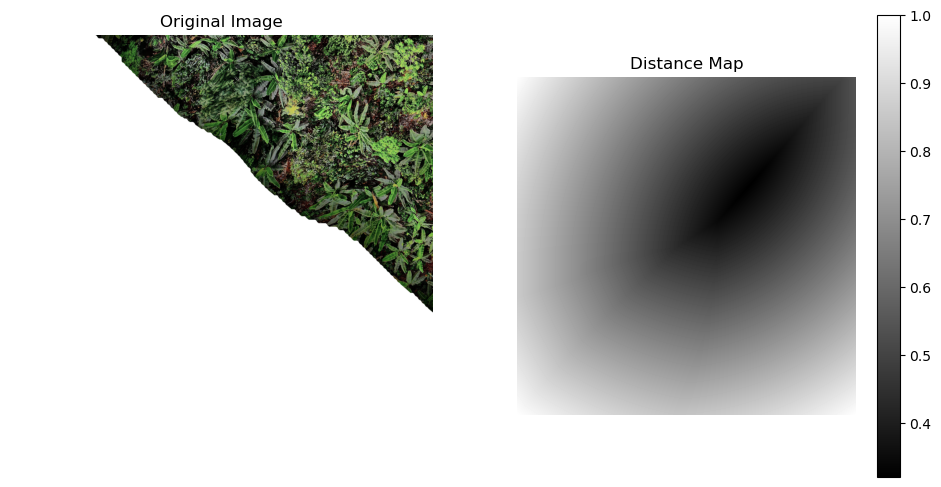

In [38]:
distance_map_dir = 'data/precomputed_distance_maps'
image_dir = 'data/tiles/processed'
img_path = 'Nestor Macias RGB_3_0_9024_4000_13024.png'  
visualize_distance_map(distance_map_dir, img_path, image_dir)

## Custom Dataset 

In [246]:
class TreeCrownDataset(Dataset):
    def __init__(self, dataframe, root_dir, split, num_crops=8, transform=None, val_size=0.15, test_size=0.15, random_state=42):
        self.root_dir = root_dir
        self.transform = transform
        self.num_crops = num_crops #the set number at 8 is for a batch size of 2, generating approximately 20000 crops per epoch

        # Split the dataframe into train, validation, and test sets
        train_val_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
        train_df, val_df = train_test_split(train_val_df, test_size=val_size / (1 - test_size), random_state=random_state)

        if split == 'train':
            self.dataframe = train_df
        elif split == 'val':
            self.dataframe = val_df
        elif split == 'test':
            self.dataframe = test_df
        else:
            raise ValueError("split must be one of 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load image
        img_path = os.path.join(self.root_dir, row['img_path'])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        # Get metadata
        species = row['name']
        species_label = 1 if species == 'Musacea' else 2 if species == 'Guaba' else 3 if species == 'Cacao' else 4 if species == 'Mango' else 5
        ID_label = row['unique_id']
        bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']], dtype=torch.float32)

        height, width, _ = image.shape

        # Generate maps
        species_map, ID_map = generate_species_and_ID_map((height, width), bbox, species_label, ID_label)
        distance_map = generate_distance_map((height, width), bbox)

        crop_size = 224

        # Initialize lists to hold multiple crops
        crop_imgs = []
        crop_species_maps = []
        crop_dist_maps = []
        crop_ID_maps = []

        count = 0

        while count < self.num_crops:
            # Random cropping logic
            x = random.randint(0, width - crop_size)
            y = random.randint(0, height - crop_size)

            crop_img = image[y:y+crop_size, x:x+crop_size]
            crop_species = species_map[y:y+crop_size, x:x+crop_size]
            crop_dist = distance_map[y:y+crop_size, x:x+crop_size]
            crop_ID = ID_map[y:y+crop_size, x:x+crop_size]

            crop_img = Image.fromarray(crop_img)
            crop_species = Image.fromarray(crop_species.astype(np.uint8))
            crop_dist = Image.fromarray(crop_dist.astype(np.float32))
            crop_ID = Image.fromarray(crop_ID.astype(np.uint8))

            if self.transform:
                crop_img = self.transform(crop_img)
                crop_species = self.transform(crop_species)
                crop_dist = self.transform(crop_dist)
                crop_ID = self.transform(crop_ID)

            # Check if the crop contains at least 10% of the tree crown
            if how_much_tree(crop_species) > 0.1:
                count += 1
                crop_imgs.append(crop_img)
                crop_species_maps.append(crop_species)
                crop_dist_maps.append(crop_dist)
                crop_ID_maps.append(crop_ID)
            else:
                continue

        # Stack lists into tensors
        crop_imgs = torch.stack(crop_imgs)
        crop_species_maps = torch.stack(crop_species_maps)
        crop_dist_maps = torch.stack(crop_dist_maps)
        crop_ID_maps = torch.stack(crop_ID_maps)

        return crop_imgs, crop_species_maps, crop_dist_maps, crop_ID_maps

## Loading and Visualizing Data

### Custom Transfomer

In [247]:
def random_rotation(image):
    rotations = [0, 90, 180, 270]
    angle = random.choice(rotations)
    return transforms.functional.rotate(image, angle)

# Define the transform pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(lambda img: random_rotation(img)),
    transforms.ToTensor()
])

In [248]:
root_dir = 'data/tiles/processed'

In [249]:
train_dataset = TreeCrownDataset(dataframe=df, root_dir=root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

val_dataset = TreeCrownDataset(dataframe=df, root_dir=root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = TreeCrownDataset(dataframe=df, root_dir=root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [250]:
start_time = time.time()

data_iter = iter(train_loader)
images, species, distance, ID = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

Time to process one batch: 3.4713449478149414 seconds


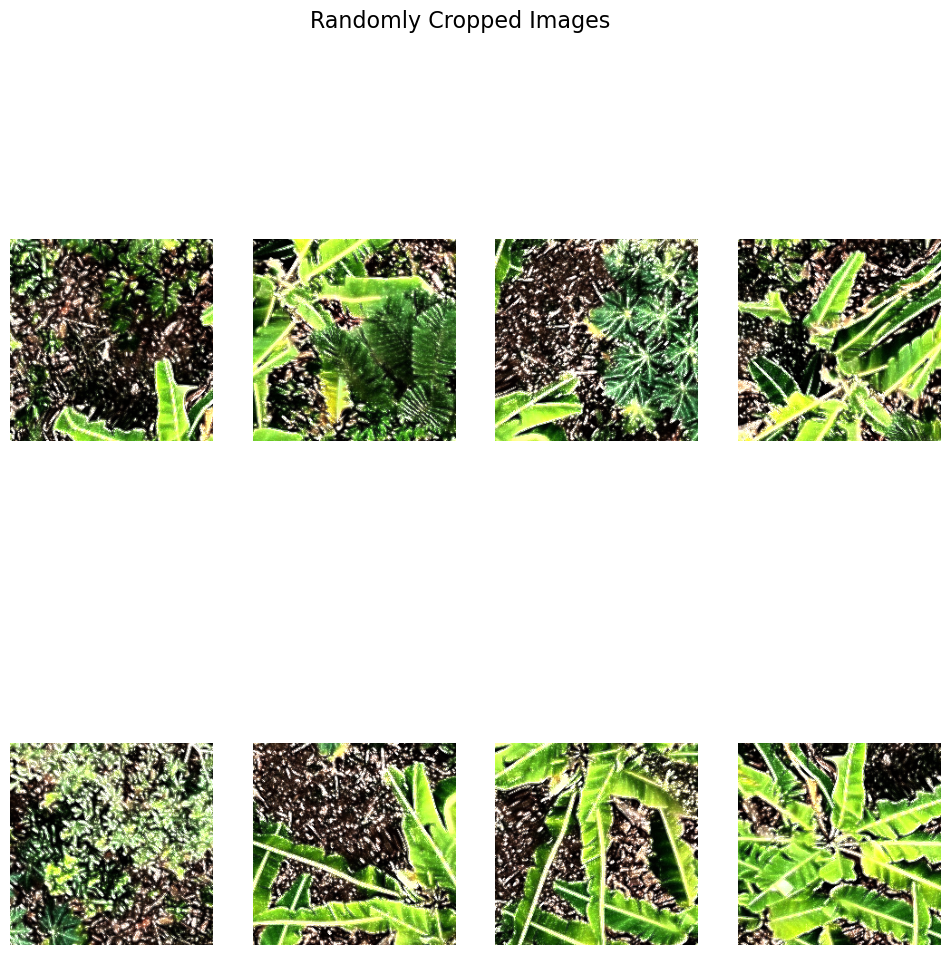

In [251]:
def show_images(images, nrow=2, ncol=4, title=None):
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12))
    if title:
        fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        if i >= nrow * ncol:
            break
        ax = axes[i // ncol, i % ncol]
        img = img.permute(1, 2, 0)  # Rearrange dimensions for matplotlib (C, H, W) -> (H, W, C)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Update the main code to visualize the images
# Get a batch of images from the dataloader
data_iter = iter(train_loader)
images, species_maps, dist_maps, ID_maps = next(data_iter)

# Select 8 random images from the batch
num_images_to_show = 8
indices = random.sample(range(images.shape[1]), num_images_to_show)

selected_images = [images[0, i] for i in indices]
selected_species = [species_maps[0, i] for i in indices]
selected_distance = [dist_maps[0, i] for i in indices]

# Show the images
show_images(selected_images, nrow=2, ncol=4, title="Randomly Cropped Images")


## Setting Device

In [252]:
#setting the device to use a GPU
def set_device(device="cpu", idx=0):
    """
    Set the device for PyTorch operations.

    Parameters:
    - device (str, optional): Device to use ("cpu" or "cuda"). Default: "cpu".
    - idx (int, optional): Index of the GPU device if using CUDA. Default: 0.

    Returns:
    - str: The selected device.
    """
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

No GPU available! Running on CPU


## Establishing the Model Architecture

In [253]:
class ResNet18Encoder(nn.Module):
    def __init__(self):
        super(ResNet18Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove last layers

    def forward(self, x):
        return self.resnet(x)

In [254]:
class SemanticSegmentationDecoder(nn.Module):
    def __init__(self, num_classes):
        super(SemanticSegmentationDecoder, self).__init__()
        self.deeplab_head = DeepLabHead(512, num_classes)  

    def forward(self, x):
        return self.deeplab_head(x)

In [255]:
class DistanceMapDecoder(nn.Module):
    def __init__(self):
        super(DistanceMapDecoder, self).__init__()
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 1, kernel_size=1)  

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.Sigmoid()(self.conv2(x))
        return x

In [256]:
class PartiallyWeightedCategoricalFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, beta=0.75):
        super(PartiallyWeightedCategoricalFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta

    def forward(self, input, target):
        # Compute cross entropy
        ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)

        # Compute focal loss
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Compute the weights
        weights = torch.where(target == 0, self.alpha, self.beta)

        # Apply the weights
        loss = weights * focal_loss

        return loss.mean()

In [257]:
class SEDDModel(nn.Module):
    def __init__(self, num_classes):
        super(SEDDModel, self).__init__()
        self.encoder = ResNet18Encoder()
        self.semantic_decoder = SemanticSegmentationDecoder(num_classes)
        self.distance_decoder = DistanceMapDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        semantic_output = self.semantic_decoder(encoded)
        distance_output = self.distance_decoder(encoded)

        semantic_output = torch.nn.functional.interpolate(semantic_output, size=(224, 224), mode='bilinear', align_corners=True)
        distance_output = torch.nn.functional.interpolate(distance_output, size=(224, 224), mode='bilinear', align_corners=True)
        
        return semantic_output, distance_output

In [283]:
def final_loss(semantic_loss, distance_loss):
    return semantic_loss + distance_loss

def fit(model, dataloader, optimizer, semantic_loss_fn, distance_loss_fn):
    model.train()
    running_loss = 0.0

    for images, targets, distance_maps, _ in dataloader:

        #reshaping from 5D tensor (batches and crops) to 4D tensor (batches*crops)
        images = images.view(-1, images.size(2), images.size(3), images.size(4))  # [B*ncrops, C, H, W]
        targets = targets.view(-1, targets.size(3), targets.size(4))  # [B*ncrops, H, W]
        distance_maps = distance_maps.view(-1, distance_maps.size(2), distance_maps.size(3), distance_maps.size(4))  # [B*ncrops, H, W]

        images = images.to(device)
        targets = targets.to(device)
        distance_maps = distance_maps.to(device)

        optimizer.zero_grad()
        semantic_outputs, distance_outputs = model(images)
        semantic_outputs_scaled = semantic_outputs * 255

        # Ensure target tensors are cast to appropriate types
        semantic_loss = semantic_loss_fn(semantic_outputs_scaled, targets.to(torch.long))  
        distance_loss = distance_loss_fn(distance_outputs, distance_maps.to(torch.float32))

        loss = final_loss(semantic_loss, distance_loss)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(dataloader.dataset)
    return train_loss

def validate(model, dataloader, semantic_loss_fn, distance_loss_fn):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, targets, distance_maps, _ in dataloader:
            #again reshaping from 5D tensor to 4D tensor
            images = images.view(-1, images.size(2), images.size(3), images.size(4))  # [B*ncrops, C, H, W]
            targets = targets.view(-1, targets.size(3), targets.size(4))  # [B*ncrops, H, W]
            distance_maps = distance_maps.view(-1, distance_maps.size(2), distance_maps.size(3), distance_maps.size(4))  # [B*ncrops, H, W]

            images = images.to(device)
            targets = targets.to(device)
            distance_maps = distance_maps.to(device, dtype=torch.float32)

            semantic_outputs, distance_outputs = model(images)
            semantic_outputs_scaled = semantic_outputs * 255

            semantic_loss = semantic_loss_fn(semantic_outputs_scaled, targets.to(torch.long))
            distance_loss = distance_loss_fn(distance_outputs, distance_maps.to(torch.float32))
            loss = final_loss(semantic_loss, distance_loss)

            running_loss += loss.item()

    val_loss = running_loss / len(dataloader.dataset)
    return val_loss

In [281]:
#print sizes of images, targets, and distance maps
images, targets, distance_maps, _ = next(iter(train_loader))
images_test = images.view(-1, images.size(2), images.size(3), images.size(4))  # [B*ncrops, C, H, W]
targets_test = targets.view(-1, targets.size(3), targets.size(4))  # [B*ncrops, H, W]
distance_maps_test = distance_maps.view(-1, distance_maps.size(2), distance_maps.size(3), distance_maps.size(4))  # [B*ncrops, H, W]


In [282]:
print(f"Images size: {images_test.size()}")
print(f"Targets size: {targets_test.size()}")
print(f"Distance maps size: {distance_maps_test.size()}")

Images size: torch.Size([16, 3, 224, 224])
Targets size: torch.Size([16, 224, 224])
Distance maps size: torch.Size([16, 1, 224, 224])


## Training the Model 

In [284]:
semantic_loss_fn = PartiallyWeightedCategoricalFocalLoss(alpha=0.25).to(device)
distance_loss_fn = nn.MSELoss().to(device)
num_epochs = 2 #set to 2 for testing
model = SEDDModel(num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [285]:
liveplot = PlotLosses()

for epoch in range(num_epochs):
    logs = {}
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    train_loss = fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn)
    val_loss = validate(model, val_loader, semantic_loss_fn, distance_loss_fn)
    
    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    liveplot.update(logs)
    liveplot.draw()

    # Save the plot to a file
    plt.savefig(f'live_plot_epoch_{epoch+1}.png')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), "SEDDModel.pth")

Epoch 1/2


## Loading Model trained on the GPU for 20 Epochs

In [52]:
model = SEDDModel(5)

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
model.load_state_dict(torch.load('SEDDModel.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [54]:
model.eval()

SEDDModel(
  (encoder): ResNet18Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, 

## Code to Evaluate

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate(model, dataloader):
    model.eval()
    all_targets = []
    all_predictions = []
    all_distances_true = []
    all_distances_pred = []

    with torch.no_grad():
        for images, targets, distance_maps, carbon, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            distance_maps = distance_maps.to(device)

            semantic_outputs, distance_outputs = model(images)
            predictions = torch.argmax(semantic_outputs, dim=1)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_distances_true.append(distance_maps.cpu().numpy())
            all_distances_pred.append(distance_outputs.cpu().numpy())

    # Flatten the arrays for metric computation
    all_targets = np.concatenate(all_targets).ravel()
    all_predictions = np.concatenate(all_predictions).ravel()
    all_distances_true = np.concatenate(all_distances_true).ravel()
    all_distances_pred = np.concatenate(all_distances_pred).ravel()

    # Compute semantic segmentation metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    # Compute distance map metrics
    mse = np.mean((all_distances_true - all_distances_pred) ** 2)

    return accuracy, precision, recall, f1, mse

### Evaluating First Model

In [58]:
model.to(device)

SEDDModel(
  (encoder): ResNet18Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, 

In [59]:
accuracy, precision, recall, f1, mse = evaluate(model, test_loader)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Distance Map MSE: {mse:.4f}')

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.9704
Test Precision: 1.0000
Test Recall: 0.9704
Test F1 Score: 0.9850
Test Distance Map MSE: 0.0009


### Looking more closely at the class metrics 

In [61]:
from sklearn.metrics import classification_report
import numpy as np

def class_wise_metrics(model, dataloader, class_names):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, targets, distance_maps, carbon, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            semantic_outputs, _ = model(images)
            predictions = torch.argmax(semantic_outputs, dim=1)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    # Flatten the arrays for metric computation
    all_targets = np.concatenate(all_targets).ravel()
    all_predictions = np.concatenate(all_predictions).ravel()

    # Verify unique classes
    unique_targets = np.unique(all_targets)
    unique_predictions = np.unique(all_predictions)
    print(f"Unique classes in targets: {unique_targets}")
    print(f"Unique classes in predictions: {unique_predictions}")

In [62]:
class_names = ['Musacea', 'Guaba', 'Cacao', 'Mango', 'Otra variedad']
class_wise_metrics(model, test_loader, class_names)

Unique classes in targets: [0]
Unique classes in predictions: [0 1 2 4]


In [222]:
def analyze_class_distribution(dataloader, class_names):
    all_targets = []

    with torch.no_grad():
        for _, targets, _, _ in dataloader:
            all_targets.append(targets.cpu().numpy())

    # Flatten the array for analysis
    all_targets = np.concatenate(all_targets).ravel()
    
    # Compute the distribution of each class
    unique, counts = np.unique(all_targets, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    return class_distribution

# Analyze class distribution in the test set
class_distribution = analyze_class_distribution(test_loader, class_names)
print("Class distribution in the test set:", class_distribution)


Class distribution in the test set: {0.0: 780376864, 0.003921569: 2527138, 0.007843138: 661365, 0.011764706: 448271, 0.015686275: 156336, 0.019607844: 582666}


In [158]:
class_distribution = analyze_class_distribution(train_loader, class_names)
print("Class distribution in the test set:", class_distribution)

Class distribution in the test set: {0: 91121735, 1: 80903, 2: 70714, 3: 16199, 4: 30769}


In [159]:
class_distribution = analyze_class_distribution(val_loader, class_names)
print("Class distribution in the test set:", class_distribution)

Class distribution in the test set: {0: 19562172, 1: 30027, 2: 17019, 3: 5041, 4: 4557}
